In [1]:
import itertools
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from sys import path

In [2]:
path.append("../Data_Generator")

In [3]:
from data_generator_gamma import DataGenerator

## 1 - Introduction to Gamma Distribution

In this study, we investigate the classification of 2D points into two distinct classes: "signal" and "background." The points are characterized by two dimensions, and each dimension is generated using different probability distributions. Specifically, the first dimension of the signal points follows a Gaussian distribution, while both dimensions of the background points are generated using the Gamma distribution.

The Gaussian distribution, also known as the normal distribution, is a continuous probability distribution defined by its mean ($\mu$) and variance ($\sigma^2$). It is commonly used to model real-valued data, with the probability density function given by:

\begin{align}
    f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}
\end{align}

On the other hand, the Gamma distribution is a continuous probability distribution defined by two parameters: shape ($k$) and scale ($\theta$). It is often employed to model positive-valued data and has a probability density function given by:

\begin{align}
    f(x) = \frac{1}{\Gamma(k) \theta^k} x^{k-1} e^{-\frac{x}{\theta}}
\end{align}

By generating points using these probability distributions, we aim to explore the discriminative power of classification algorithms in distinguishing between the signal and background classes.

In [4]:
from scipy.stats import gamma

def plot_distribution(k, tau):
    x = np.linspace(0, 10*tau, 1000)  # generate x values from 0 to 10t
    pdf = gamma.pdf(x, a=k, scale=tau)  # compute the PDF of the Gamma distribution
    
    fig, ax = plt.subplots()  # create a new figure and axis object
    ax.plot(x, pdf, label='PDF', c="b")  # plot the PDF of the Gamma distribution
    ax.set_xlabel('x')  # set the x-axis label
    ax.set_ylabel('Probability density')  # set the y-axis label
    ax.set_title(f'Gamma distribution for k={k}, tau={tau}')  # set the plot title
    plt.legend()  # show the legend
    plt.show()  # show the plot

# Example usage:
plot_distribution(k=2, tau=40)

## 2 - Data generation

In [5]:
# We set parameters value and compute a cartesian product to explore all possible combination of parameters

# Task's parameters
search_space = {}
search_space["p"] = [0.05, 0.5]
search_space["b_k_1"] = [("Gamma",2)]
search_space["b_tau_1"] = [50]
search_space["b_k_2"] = [("Gamma",2)]
search_space["b_tau_2"] = [20]
search_space["s_mu_1"] = [("Gaussian",100)]
search_space["s_sigma_1"] = [10,30]
search_space["s_k_2"] = [("Gamma",3)]
search_space["s_tau_2"] = [20]
search_space_iter = list(itertools.product(search_space["p"],search_space["b_k_1"],search_space["b_tau_1"],
                                           search_space["b_k_2"],search_space["b_tau_2"],search_space["s_mu_1"],
                                           search_space["s_sigma_1"],search_space["s_k_2"],search_space["s_tau_2"]))

# Systematic's parameters
search_z = {}
search_z["delta_k_1"] = [-1,2]
search_z["delta_tau_1"] = [10,20]
search_z["delta_k_2"] = [1,3]
search_z["delta_tau_2"] = [-10,20]
search_space_bias_iter = list(itertools.product(search_z["delta_k_1"],search_z["delta_tau_1"],search_z["delta_k_2"],search_z["delta_tau_2"]))

# Define main path of data
path = ".\\sample_gamma_data/"
# Create the file that will be used to store the binding between folders name and parameters value
param_values_file = path+"/parameters_values.json"
with open(param_values_file, 'w') as file:
    json.dump({}, file)
# Choose the modes. Either "Gaussian" or "Gaussian_Gamma"
data_mode = "Gaussian_Gamma"
bias_mode = "Gamma_Perturbation"

In [6]:
def updateJsonFile_new(params,SamplejsonFileName,systematics,mode="Gaussian"):
    # Open a json file with the appropriate structure and main parameters (dimensions, number of events...)
    # This file is updated each time this function is called
    jsonFile = open(SamplejsonFileName, "r") 
    data = json.load(jsonFile) # Read the JSON into the buffer
    jsonFile.close() # Close the JSON file
    
    if mode == "Gaussian" :
        # Edit the file with our values of the parameters of interest
        data["signal_sigma_scale"] = params["sigmaS"]
        data["theta"] = params["theta"]
        data["L"] = params["l"]

        data["p_b"] = 1-params["p"]
        data["z_magnitude"] = systematics[1]
        data["alpha"] = systematics[0]
    elif mode == "Gaussian_Gamma" :
        # Edit the file with our values of the parameters of interest
        data["background_dim_1"] = params["background_dim_1"]
        data["background_dim_2"] = params["background_dim_2"]
        data["signal_dim_1"] = params["signal_dim_1"]
        data["signal_dim_2"] = params["signal_dim_2"]
        
        data["delta_k_1"] = systematics[0]
        data["delta_tau_1"] = systematics[1]
        data["delta_k_2"] = systematics[2]
        data["delta_tau_2"] = systematics[3]
    else :
        print("Unknown mode name")
        return None

    # Save the changes to the json file
    jsonFile = open(SamplejsonFileName, "w+")
    jsonFile.write(json.dumps(data))
    jsonFile.close()

In [7]:
try :
    jsonFile = open(param_values_file, "r") 
    param_values = json.load(jsonFile)
    jsonFile.close()
except :
    param_values = {}

for i,search_combination in enumerate(search_space_iter) :
    # Get task parameters
    params = {}
    params["p"] = search_combination[0]
    params["background_dim_1"] = {"distrib" : search_combination[1][0],"param_1" : search_combination[1][1],"param_2" : search_combination[2]}
    params["background_dim_2"] = {"distrib" : search_combination[3][0],"param_1" : search_combination[3][1],"param_2" : search_combination[4]}
    params["signal_dim_1"] = {"distrib" : search_combination[5][0],"param_1" : search_combination[5][1],"param_2" : search_combination[6]}
    params["signal_dim_2"] = {"distrib" : search_combination[7][0],"param_1" : search_combination[7][1],"param_2" : search_combination[8]}
    
    # Create task directory and training directory if needed
    TaskParamsList = [params["p"], params["background_dim_1"], params["background_dim_2"], params["signal_dim_1"], params["signal_dim_2"]]
    TaskID = "task_"+str(i)
    task_dir = path+TaskID
    try :
        os.mkdir(task_dir)
    except :
        pass
    
    # Generate test data
    for j,systematics in enumerate(search_space_bias_iter) :
        # Create bias directory if needed
        BiasParamsList = list(systematics)
        BiasID = "bias_"+str(j)
        bias_dir = task_dir + "/" + BiasID
        try :
            os.mkdir(bias_dir)
        except :
            pass
        
        # Store the binding between folder and bias parameters values 
        param_values[TaskID+"_"+BiasID] = TaskParamsList + BiasParamsList

        # Update the json file with settings for the task and sytematics
        updateJsonFile_new(params,"sample_settings_gamma.json",systematics, data_mode)

        # Load settings
        jsonFile = open("sample_settings_gamma.json", "r")
        settings = json.load(jsonFile)
        jsonFile.close()

        # Generate test data
        # Remark : here is also generated train data with null bias that is to be ignored
        data_test = DataGenerator(settings_dict=settings,data_mode=data_mode, bias_mode=bias_mode)
        data_test.load_settings()
        data_test.generate_data()
        data_test.save_data(bias_dir, file_index=1)

jsonFile = open(param_values_file, "w+")
jsonFile.write(json.dumps(param_values))
jsonFile.close()

print("---Datapoints have been properly generated---")

---Datapoints have been properly generated---


## 3 - Loading generated data

In [8]:
from ingestion_program.data_io import load_data

In [9]:
train_sets,test_sets,settings = [],[],[]
i = 0
for task_dir in os.listdir(path) :
    if task_dir != "parameters_values.json" :
        for bias_dir in os.listdir(path+task_dir+"/") :
            full_dir = path+task_dir+"/"+bias_dir
            train_set, test_set, setting = load_data(full_dir, load_settings=True)
            train_sets.append(train_set[0])
            test_sets.append(test_set[0])
            settings.append(setting[0])




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_data/task_0/bias_0
[*] train data dir :  .\sample_gamma_data/task_0/bias_0\train\data
[*] train labels dir :  .\sample_gamma_data/task_0/bias_0\train\labels
[*] test data dir :  .\sample_gamma_data/task_0/bias_0\test\data
[*] test labels dir :  .\sample_gamma_data/task_0/bias_0\test\labels
[*] settings dir :  .\sample_gamma_data/task_0/bias_0\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 1 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_data/task_0/bias_1
[*] train data dir :  .\sample_gamma_data/task_0/bias_1\train\data
[*] train labels dir : 

---------------------------------
[+] Train and Test data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_data/task_0/bias_6
[*] train data dir :  .\sample_gamma_data/task_0/bias_6\train\data
[*] train labels dir :  .\sample_gamma_data/task_0/bias_6\train\labels
[*] test data dir :  .\sample_gamma_data/task_0/bias_6\test\data
[*] test labels dir :  .\sample_gamma_data/task_0/bias_6\test\labels
[*] settings dir :  .\sample_gamma_data/task_0/bias_6\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 1 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_data/ta

---------------------------------
[+] Train and Test data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_data/task_1/bias_5
[*] train data dir :  .\sample_gamma_data/task_1/bias_5\train\data
[*] train labels dir :  .\sample_gamma_data/task_1/bias_5\train\labels
[*] test data dir :  .\sample_gamma_data/task_1/bias_5\test\data
[*] test labels dir :  .\sample_gamma_data/task_1/bias_5\test\labels
[*] settings dir :  .\sample_gamma_data/task_1/bias_5\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 1 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_data/ta

---------------------------------
[+] Train and Test data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_data/task_2/bias_2
[*] train data dir :  .\sample_gamma_data/task_2/bias_2\train\data
[*] train labels dir :  .\sample_gamma_data/task_2/bias_2\train\labels
[*] test data dir :  .\sample_gamma_data/task_2/bias_2\test\data
[*] test labels dir :  .\sample_gamma_data/task_2/bias_2\test\labels
[*] settings dir :  .\sample_gamma_data/task_2/bias_2\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 1 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_data/ta

---------------------------------
[+] Train and Test data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_data/task_3/bias_12
[*] train data dir :  .\sample_gamma_data/task_3/bias_12\train\data
[*] train labels dir :  .\sample_gamma_data/task_3/bias_12\train\labels
[*] test data dir :  .\sample_gamma_data/task_3/bias_12\test\data
[*] test labels dir :  .\sample_gamma_data/task_3/bias_12\test\labels
[*] settings dir :  .\sample_gamma_data/task_3/bias_12\settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 1 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  .\sample_gamma_d

## 4 - Visualization

In [10]:
from ingestion_program.visualize import (visualize_scatter_gamma,
                                         visualize_pair_plot)

C:\Users\mathi\Bureau\Bahut\M1\Interships\CERN\GitHub\Ihsan\fair-universe\starting_kit\ingestion_program\visualize.py:547: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(constrained_layout=True, figsize=(6,3))


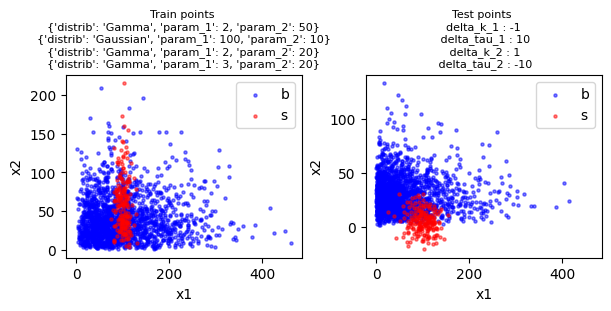

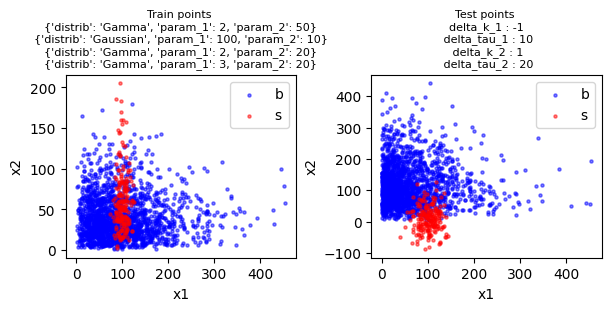

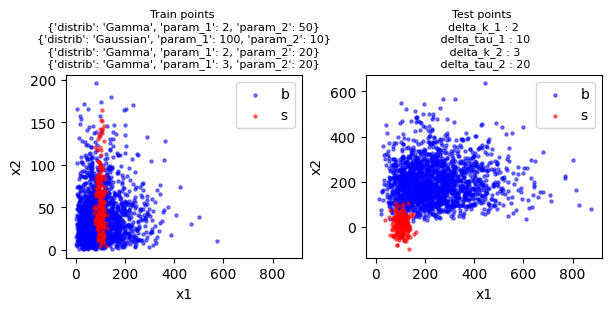

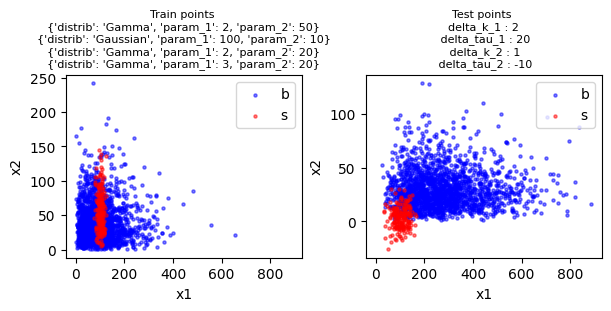

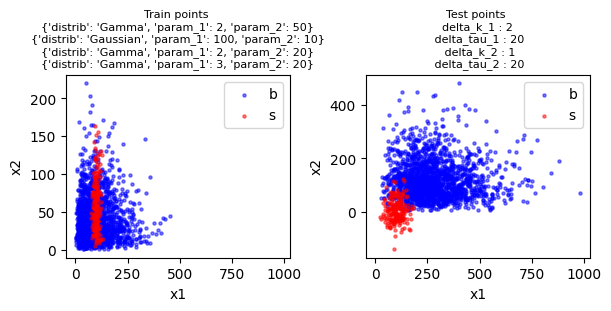

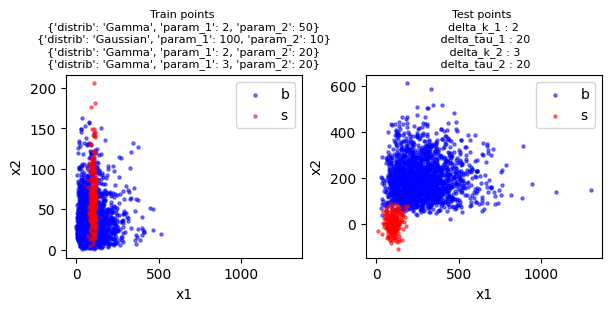

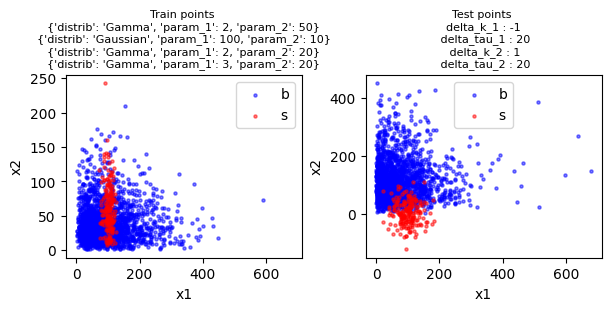

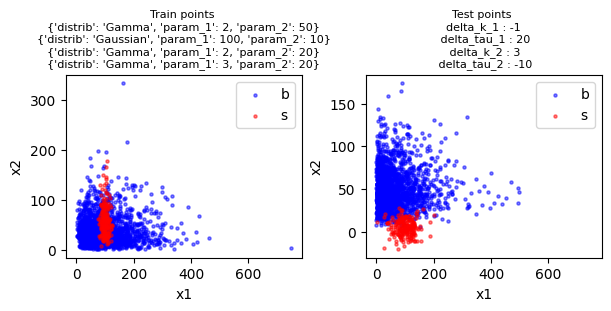

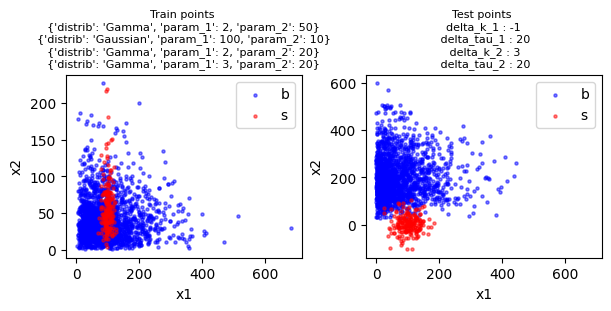

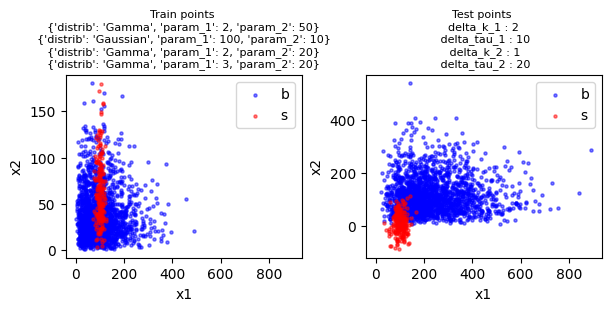

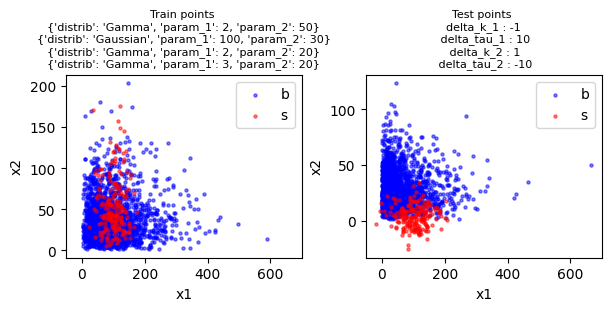

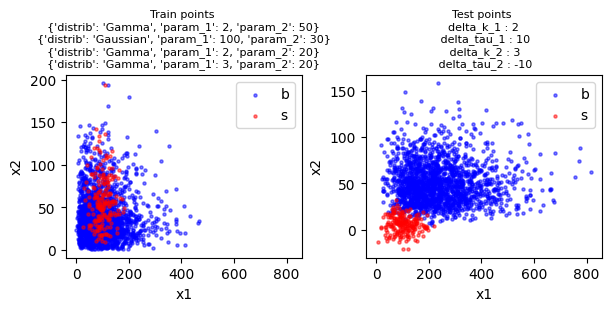

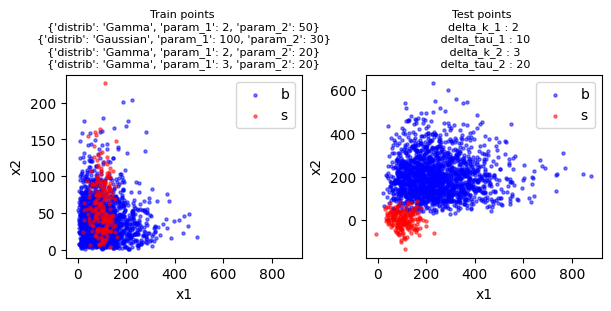

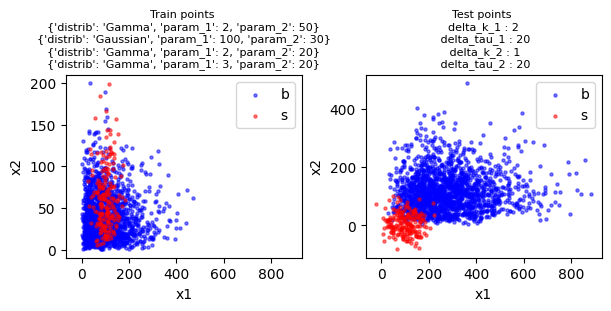

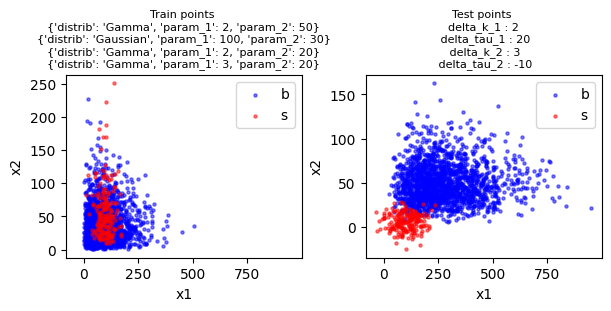

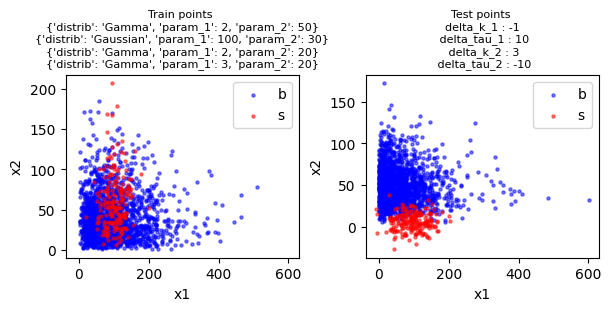

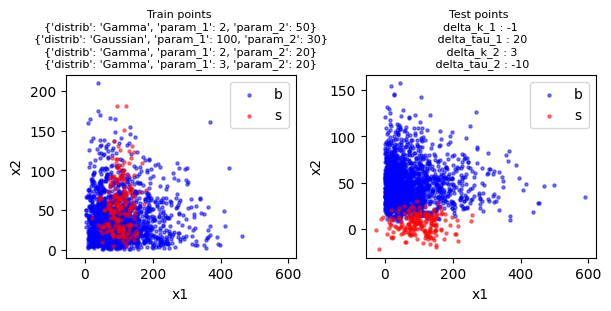

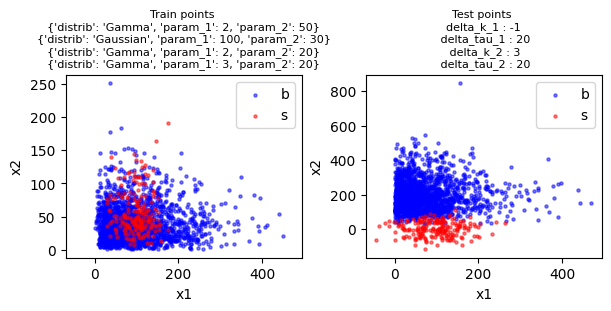

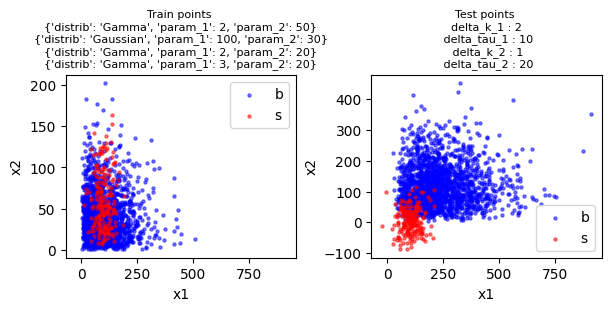

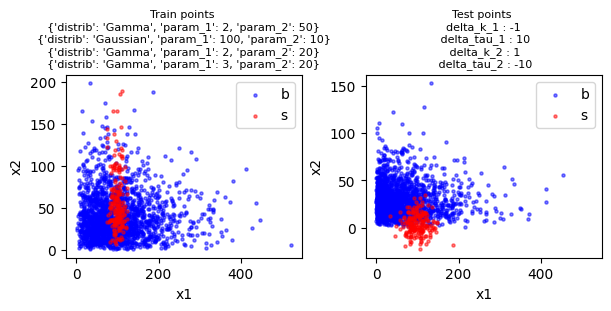

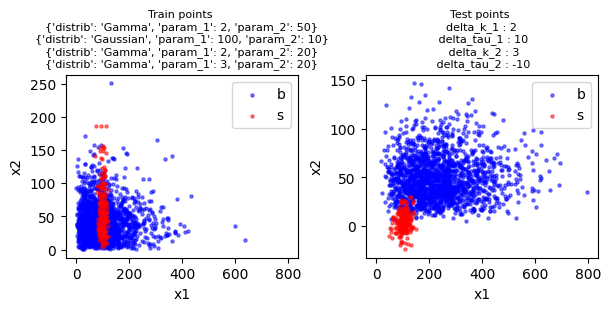

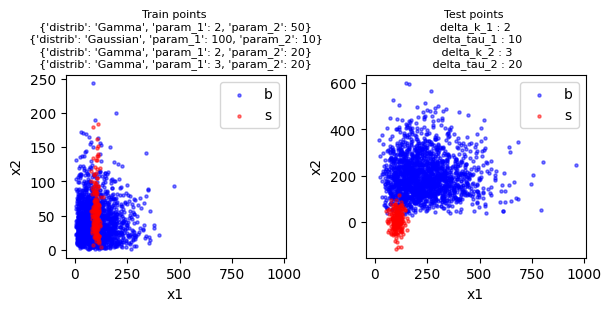

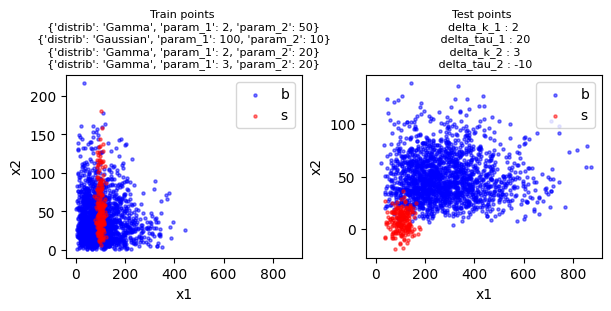

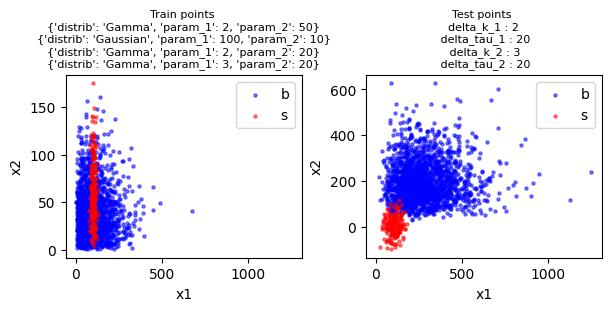

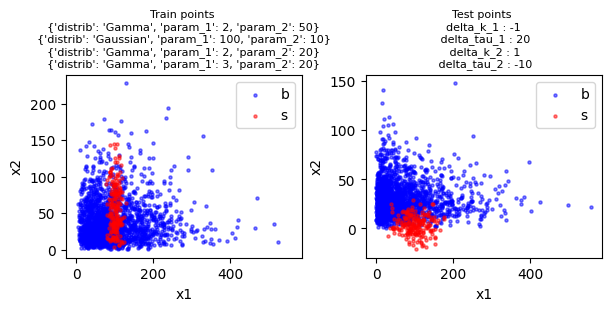

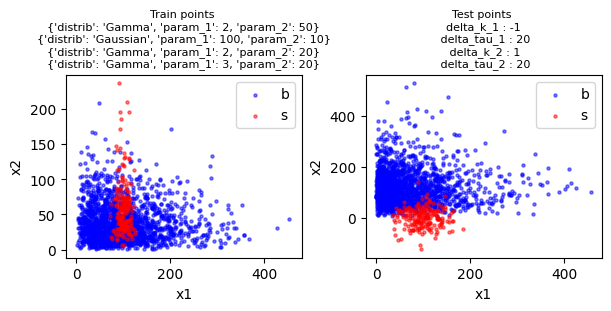

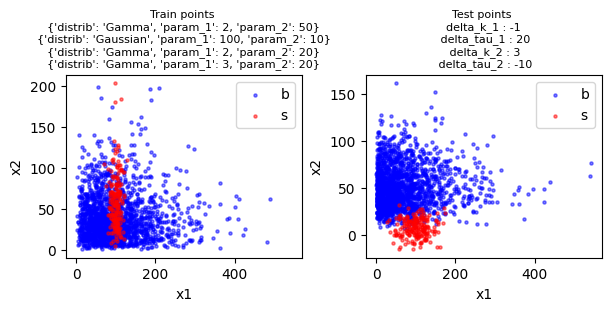

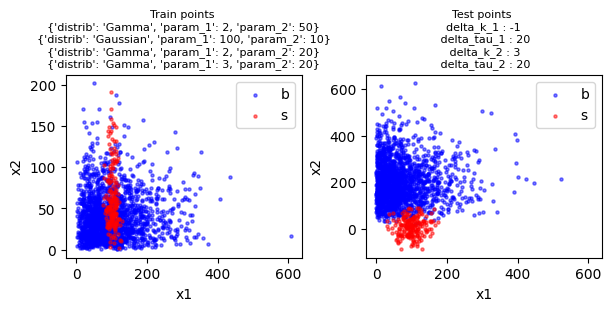

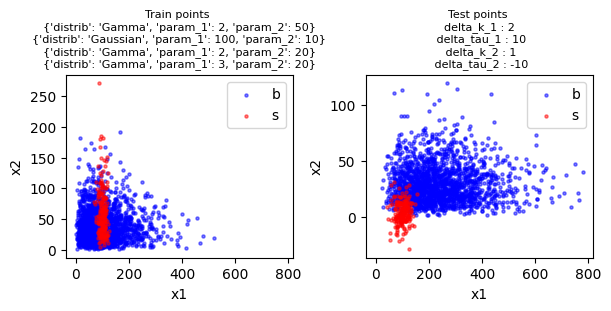

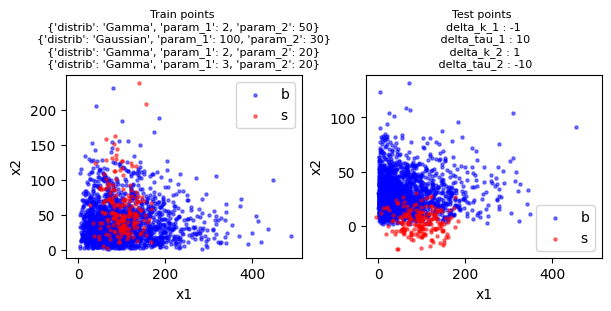

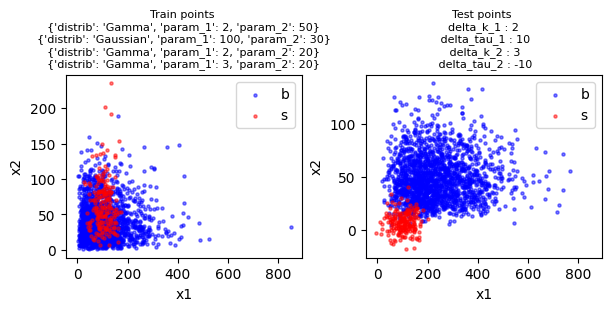

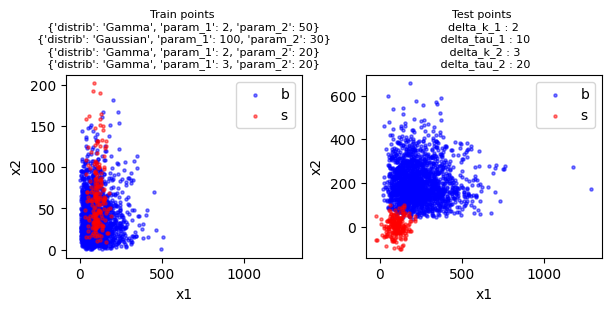

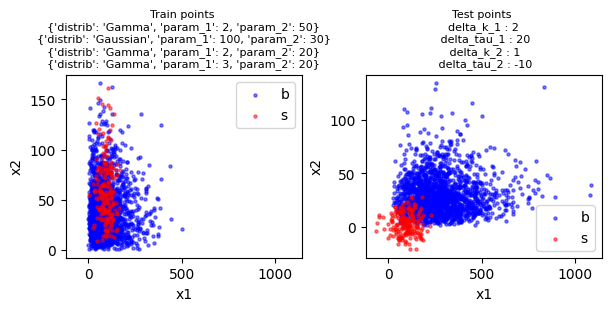

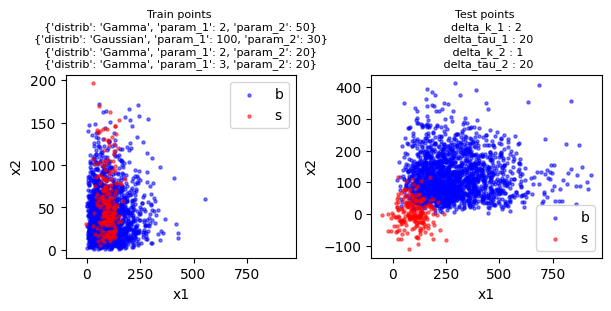

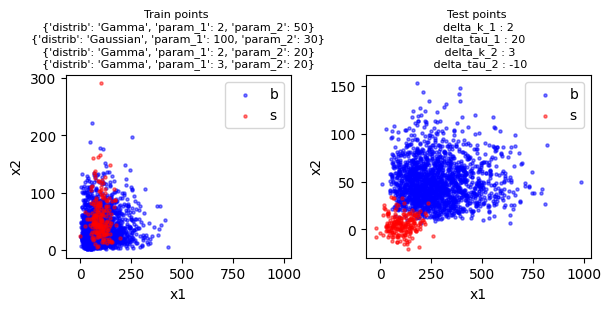

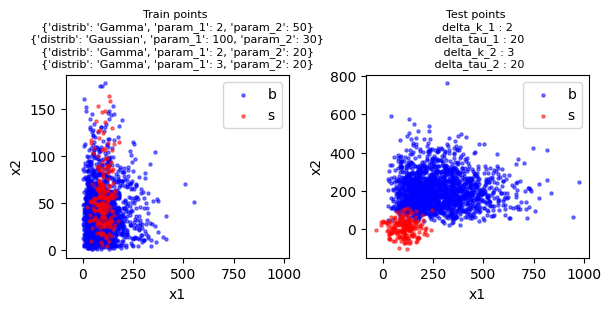

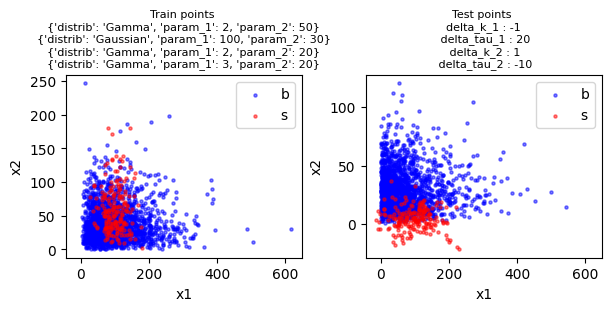

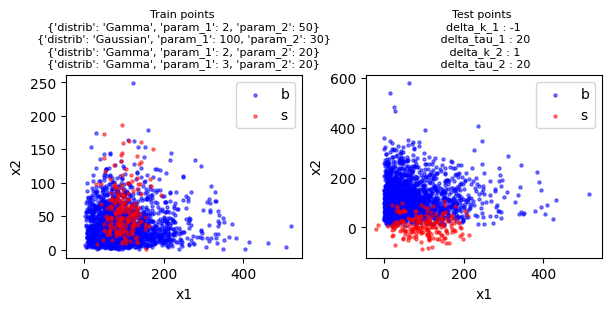

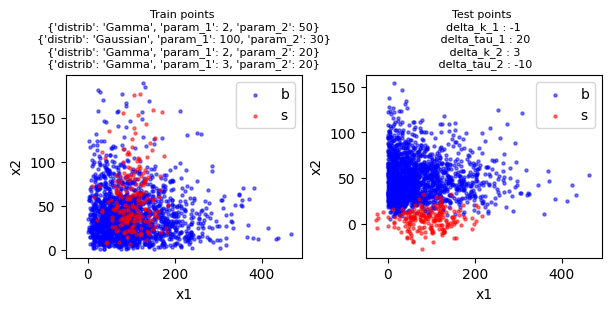

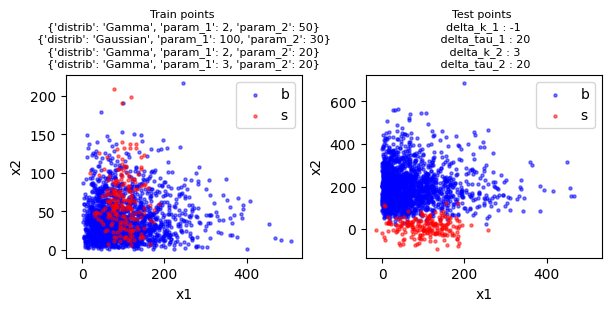

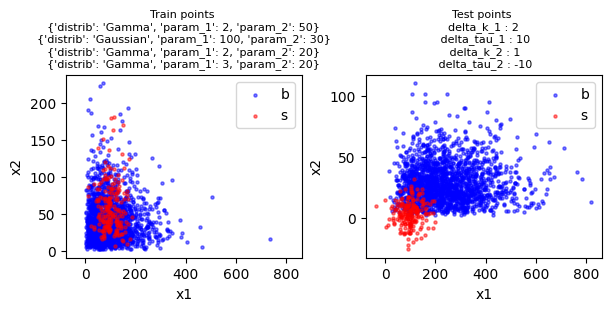

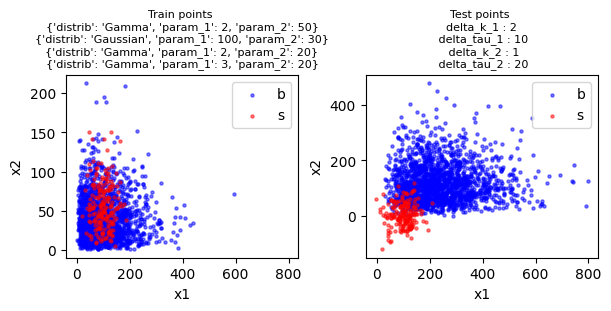

In [11]:
for train_set,test_set,setting in zip(train_sets,test_sets,settings) :
    visualize_scatter_gamma(train_set,test_set,setting)

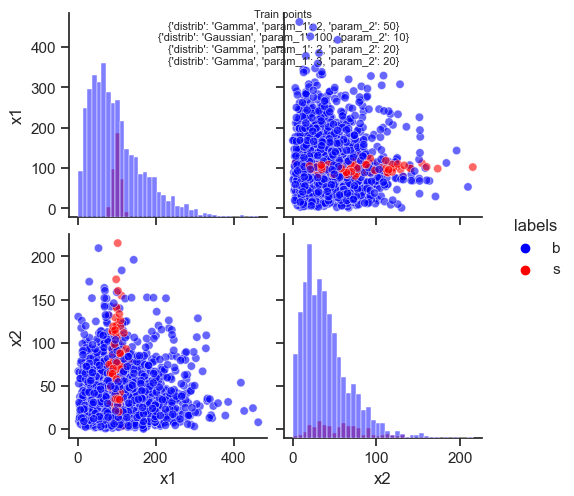

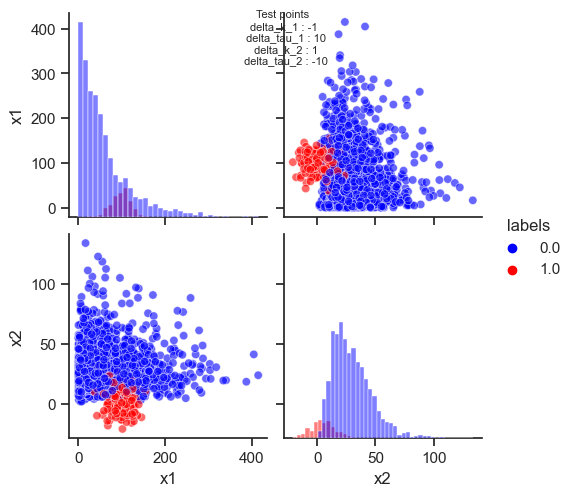

In [12]:
visualize_pair_plot(train_sets[0],test_sets[0],settings[0])